# DKTC
> Dataset of Korean Threatening Conversations

1. DKTC 훈련 데이터를 이용해 협박, 갈취, 직장 내 괴롭힘, 기타 괴롭힘, 일반 대화 5가지 대화 유형 Class를 분류하는 딥러닝 모델을 만듭니다.
2. DKTC 테스트 데이터를 활용해 분류 성능을 평가합니다.

## TODO
- [ ] 데이터 EDA와 데이터 전처리가 적절하게 이뤄졌는가?
- [ ] Task에 알맞게 적절한 모델을 찾아보고 선정했는가?
- [ ] 성능향상을 위해 논리적으로 접근했는가?
- [ ] 결과 도출을 위해 여러가지 시도를 진행했는가?
- [ ] 도출된 결론에 충분한 설득력이 있는가?
- [ ] 적절한 metric을 설정하고 그 사용 근거 및 결과를 분석하였는가?
- [ ] 발표가 매끄럽게 진행되었고 발표시간을 준수하였는지?

In [58]:
# !mkdir -p ~/aiffel/dktc
# !ln -s ~/data/ ~/aiffel/dktc
!ls -al ~/data

total 2700
drwxr-xr-x 3 root root    4096 Jun 20 02:44 .
drwxrwxrwx 1 root root    4096 Jun 24 07:39 ..
drwxr-xr-x 2 root root    4096 Aug 29  2023 .ipynb_checkpoints
-rw-r--r-- 1 root root    3215 Jun 20 02:44 submission.csv
-rw-r--r-- 1 root root  499744 Jun 20 02:38 test.json
-rw-r--r-- 1 root root 2239660 Aug 28  2023 train.csv


# Proposal

## Intro
구하기 쉬운 일반 데이터를 사용해서 일반 또는 비정상인지 분류하는 모델을 생성하여 각각 학습합니다. 추론단계에서 비정상으로 분류되었다면, softmax로 single label classification 모델을 통과시켜 최종 정답을 분류합니다.

- 학습단계에서 word embedding과 tokenizer는 공유합니다.
- 일반 텍스트의 갯수는 비정상 텍스트 총 갯수와 같도록 만듭니다.

1. Binary classification: 일반/비정상 분류 모델 (0 or 1)
2. Multiclass classification: 비정상 분류 모델 (0 ~ 3)

## Data

## Model

## 

# 1. EDA


- [tunib data](https://github.com/tunib-ai/DKTC)

1. idx = 인덱스
2. class = 0~4
  - class 0; 협박 대화
  - class 1; 갈취 대화
  - class 2; 직장 내 괴롭힘 대화
  - class 3; 기타 괴롭힘 대화
3. conversation = \n으로 구분된 멀티턴 텍스트 대화

In [31]:
import os
import pandas as pd

df_path ="~/aiffel/dktc/data/train.csv"
df = pd.read_csv(df_path)
df.head()

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


In [32]:
# !pip install soynlp tqdm
!pip list | grep -i soynlp

soynlp                        0.0.493


## 1. Preprocessing
> https://huggingface.co/beomi/KcELECTRA-base#preprocessing


In [33]:
print(len(df))
df = df.drop(columns=['idx'])
df.drop_duplicates(subset = ['conversation'], inplace = True)
print(len(df))

3950
3846


In [34]:
import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas()

import re
from soynlp.normalizer import repeat_normalize

pattern = re.compile(f'[^ .,?!/@$%~％·∼()\x00-\x7Fㄱ-ㅣ가-힣]+')
url_pattern = re.compile(
    r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)')

def preprocess(x): 
    x = pattern.sub(' ', x)
    x = url_pattern.sub('', x)
    x = x.strip()
    x = repeat_normalize(x, num_repeats=3) 
    return x

def postprocess(df):
    df.replace('', np.nan, inplace=True)
    df.dropna(subset=['conversation'], inplace=True)


print(len(df))
df['conversation'] = df['conversation'].progress_apply(preprocess)
postprocess(df)
print(len(df))

3846


  0%|          | 0/3846 [00:00<?, ?it/s]

3846


In [35]:
df.groupby('class').count()

,conversation
class,
갈취 대화,973
기타 괴롭힘 대화,1011
직장 내 괴롭힘 대화,970
협박 대화,892


In [36]:
import seaborn as sns

def min_len(series):
    return series.str.len().min()

def max_len(series):
    return series.str.len().max()

def avg_len(series):
    return series.str.len().mean()


print(f"전체 최소 길이 : {min_len(df['conversation'])}")
print(f"전체 최대 길이 : {max_len(df['conversation'])}")
print(f"전체 평균 길이 : {avg_len(df['conversation'])}")
print()
    
for cls in ('협박 대화', '갈취 대화', '기타 괴롭힘 대화', '직장 내 괴롭힘 대화'):
    cls_data = df[df['class'] == cls]['conversation']
    print(f"{cls} 최소 길이 : {min_len(cls_data)}")    
    print(f"{cls} 최대 길이 : {max_len(cls_data)}")
    print(f"{cls} 평균 길이 : {avg_len(cls_data)}")
    print()

전체 최소 길이 : 41
전체 최대 길이 : 874
전체 평균 길이 : 225.6916276651066

협박 대화 최소 길이 : 57
협박 대화 최대 길이 : 818
협박 대화 평균 길이 : 243.88677130044843

갈취 대화 최소 길이 : 45
갈취 대화 최대 길이 : 667
갈취 대화 평균 길이 : 214.23021582733813

기타 괴롭힘 대화 최소 길이 : 41
기타 괴롭힘 대화 최대 길이 : 874
기타 괴롭힘 대화 평균 길이 : 211.22551928783383

직장 내 괴롭힘 대화 최소 길이 : 41
직장 내 괴롭힘 대화 최대 길이 : 843
직장 내 괴롭힘 대화 평균 길이 : 235.5340206185567



#### matplot 폰트 설치

In [37]:
# !apt-get install -y fonts-nanum

In [38]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

plt.rc('font', family='NanumGothic')

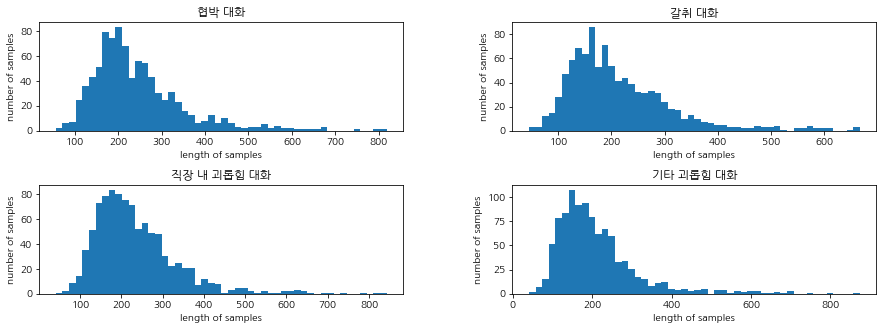

In [39]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 5))

# Plot the histogram of sample lengths
axes[0][0].hist([len(s) for s in df['conversation'][df['class']=='협박 대화']], bins=50)
axes[0][0].set_xlabel('length of samples')
axes[0][0].set_ylabel('number of samples')
axes[0][0].set_title('협박 대화')

axes[0][1].hist([len(s) for s in df['conversation'][df['class']=='갈취 대화']], bins=50)
axes[0][1].set_xlabel('length of samples')
axes[0][1].set_ylabel('number of samples')
axes[0][1].set_title('갈취 대화')

axes[1][0].hist([len(s) for s in df['conversation'][df['class']=='직장 내 괴롭힘 대화']], bins=50)
axes[1][0].set_xlabel('length of samples')
axes[1][0].set_ylabel('number of samples')
axes[1][0].set_title('직장 내 괴롭힘 대화')

axes[1][1].hist([len(s) for s in df['conversation'][df['class']=='기타 괴롭힘 대화']
], bins=50)
axes[1][1].set_xlabel('length of samples')
axes[1][1].set_ylabel('number of samples')
axes[1][1].set_title('기타 괴롭힘 대화')

plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

# 일상대화
> https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=data&dataSetSn=543

1. 파일 하나를 하나의 communication column으로 사용한다.
2. 서로 다른 발화자의 경우 \n으로 이어 붙이고, 이외의 \n는 모두 제거한다.


> curl -o "aihubshell" https://api.aihub.or.kr/api/aihubshell.do

```sh
> ls
KAKAO_532_08.txt  KAKAO_621_20.txt  KAKAO_713_12.txt  KAKAO_803_04.txt  KAKAO_892_16.txt
KAKAO_532_09.txt  KAKAO_622_01.txt  KAKAO_713_13.txt  KAKAO_803_05.txt  KAKAO_892_17.txt
KAKAO_532_10.txt  KAKAO_622_02.txt  KAKAO_713_14.txt  KAKAO_803_06.txt  KAKAO_892_18.txt
KAKAO_532_11.txt  KAKAO_622_03.txt  KAKAO_713_15.txt  KAKAO_803_07.txt  KAKAO_892_19.txt
KAKAO_532_12.txt  KAKAO_622_04.txt  KAKAO_713_16.txt  KAKAO_803_08.txt  KAKAO_892_20.txt
KAKAO_532_13.txt  KAKAO_622_05.txt  KAKAO_713_17.txt  KAKAO_803_09.txt  KAKAO_893_01.txt
KAKAO_532_14.txt  KAKAO_622_06.txt  KAKAO_713_18.txt  KAKAO_803_10.txt  KAKAO_893_02.txt
KAKAO_532_15.txt  KAKAO_622_07.txt  KAKAO_713_19.txt  KAKAO_803_11.txt  KAKAO_893_03.txt
KAKAO_532_16.txt  KAKAO_622_08.txt  KAKAO_713_20.txt  KAKAO_803_12.txt  KAKAO_893_04.txt
KAKAO_532_17.txt  KAKAO_622_09.txt  KAKAO_714_01.txt  KAKAO_803_13.txt  KAKAO_893_05.txt
KAKAO_532_18.txt  KAKAO_622_10.txt  KAKAO_714_02.txt  KAKAO_803_14.txt  KAKAO_893_06.txt
KAKAO_532_19.txt  KAKAO_622_11.txt  KAKAO_714_03.txt  KAKAO_803_15.txt  KAKAO_893_07.txt
```

#### KAKAO_897_05.txt
```
1 : 언니 혹시 피엑스 가봤어?
2 : 당연하지 거기 엄청 유명하잖아
1 : 헐 키키 대박 어떻게 갔었어?
2 : 아는 분 아빠가 직군이셔 하하
1 : 아하! 가서 달팽이크림 쓸어왔겠네?
2 : 무거워서 들 수 있는 만큼 사온 거 같아
1 : 거기 냉장식품도 많다던데?
1 : 치킨이 유명해 키키
2 : 맞아 크림치킨이였나?
2 : 냉동 피자도 팔아 거기 키키
1 : 어 맞아 키키 그리고 과자가 엄청 싸더라
2 : 편의점 1500원이 거기 500원이더라...
1 : 이야... 언니 우리 입대할까? 키키
2 : 내 인생 망하는 지름길일 듯... [이모티콘]
1 : 아 그거 킹정 키키 절대 안 가
2 : 그냥 거기 친구 만들어서 맨날 방문할래
1 : 아니면 남편으로는 어때? 키키
2 : 어 난 그닥... 결혼 안 할려고 ^^
```

```py
import multiprocessing
import os

import pandas as pd

txt_files = [f for f in os.listdir() if f.endswith(".txt")]
output_file = "output.csv"


def process_file(file_path):
    try:
        # 파일 읽기
        with open(file_path, "r", encoding="utf-8") as file:
            lines = file.readlines()

        communication = ""
        current_speaker = None
        for line in lines:
            if line.strip():
                speaker, message = line.split(":", 1)
                speaker = speaker.strip()
                message = message.strip().replace("\n", " ")

                if current_speaker is None:
                    current_speaker = speaker
                    communication += message
                elif speaker == current_speaker:
                    communication += ". " + message
                else:
                    communication += "\n" + message
                    current_speaker = speaker

        # 뮤텍스를 사용하여 CSV 파일에 기록
        with lock:
            df = pd.DataFrame([{"communication": communication}])
            if not os.path.exists(output_file):
                df.to_csv(output_file, index=False, encoding="utf-8-sig")
            else:
                df.to_csv(
                    output_file,
                    mode="a",
                    header=False,
                    index=False,
                    encoding="utf-8-sig",
                )

    except ValueError:
        # When split error occurs, pass
        pass


def initialize_lock(l):
    global lock
    lock = l


if __name__ == "__main__":
    lock = multiprocessing.Lock()

    with multiprocessing.Pool(
        processes=min(multiprocessing.cpu_count(), 8),
        initializer=initialize_lock,
        initargs=(lock,),
    ) as pool:
        pool.map(process_file, txt_files)

```


In [21]:
import os
import pandas as pd


normal = pd.read_csv("./normal_communication.csv")
normal.head()

,communication
0,왜 전화 했어?\n동생한테 연락 온 거 있니?\n없엉 왜? 무슨 일 있어?\n아니 ...
1,언니 친척 오빠가 시월에 결혼식 한다고 청첩장을 보냈더라구 하하\n역시 시월은 결혼...
2,회사에 업무 보는 건 편하나?\n네 적응돼서 괜찮아서 하하\n수습 기간도 있제?\n...
3,요새 티비에 전원주택 싸게 많이 나온다 저거 괜찮나?\n요새 눈이 높아져서 자꾸 전...
4,너 웹툰 요일마다 보는 거 정해져 있어?\n음 보는 게 정해져 있긴 하지?\n요일마...


In [22]:
normal.drop_duplicates(subset = ['communication'], inplace = True)
normal['communication'] = normal['communication'].progress_apply(preprocess)

normal.replace('', np.nan, inplace=True)
normal.dropna(subset=['communication'], inplace=True)
print(f"일반대화 최소 길이 : {min_len(normal['communication'])}")
print(f"일반대화 최대 길이 : {max_len(normal['communication'])}")
print(f"일반대화 평균 길이 : {avg_len(normal['communication'])}")

  0%|          | 0/8877 [00:00<?, ?it/s]

일반대화 최소 길이 : 25
일반대화 최대 길이 : 1406
일반대화 평균 길이 : 486.69550523825615


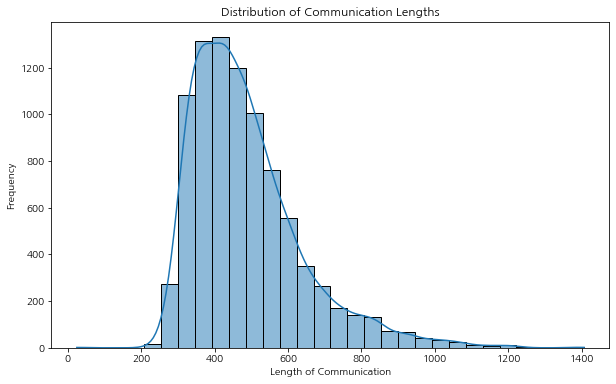

In [30]:
normal['length'] = normal['communication'].str.len()

# Plot histogram using Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(normal['length'], bins=30, kde=True)
plt.title('Distribution of Communication Lengths')
plt.xlabel('Length of Communication')
plt.ylabel('Frequency')
plt.show()

# 일상 대화 + 비정상대화

1. 일상대화 갯수 맞추기
2. 일상대화 길이 맞추기(비정상대화 평균길이)

In [56]:
df['length'] = df['conversation'].str.len()

In [64]:
min_length = 100
optimal_length = 430

normal = normal[(normal['length'] <= optimal_length) & (normal['length'] > min_length)]
abnormal = df[(df['length'] <= optimal_length) & (df['length'] > min_length)]

print(len(normal), len(abnormal))

3748 3527


In [69]:
abnormal.sample(5)

,class,conversation,length
1210,갈취 대화,야 돈 있어? 나 어디에 급하게 쓸 돈이 필요한데 부족하네. 좀 줄 수 있어? 아니...,339
739,갈취 대화,야 00아 이것 좀 매점에서 사다줘 아 응 돈은? 아 미안미안 내가 지금 현금이 없...,190
412,갈취 대화,애들아 나 이번에 반지 샀어! 뭐야 ? 우와 그거 비싼 거 아냐? 응 갖고 싶었던 ...,305
3265,협박 대화,이여편네가 언제들어올래 아 곧갈게요 언제오냐고 이여편네야 네 장봐서 10분후에 들어...,128
2222,협박 대화,너 내 말 안들어주면 목 졸라 죽여버릴 거야 목 졸라서 사람 죽이면 감방 간다 그러...,186


In [68]:
normal.sample(5)

,communication,length
622,언니 런닝맨 봐? 옛날에는 봤었는데 요즘에는 잘 안 봐. 왜? 아 광수가 빠졌거든?...,338
5706,나 엄마가 학원비 대 준다고 배우고 싶은 거 배우래 키키 나도 니네 집 양녀로 들어...,353
7031,나 이번에 회사에 발령 나서 충북으로 내려가 ㅠㅠ 헐 ㅠㅠ 되게 멀리 가네 집은 어...,341
3507,코로나 백신 1차 맞고 2차 언제 맞냐? 나 원래 9월 말이었는데 밀려서 10월 초...,345
4353,너 남자친구 군대에 있지 않아? 이제 곧 가는데 무슨 소리야! 키키 아 맞나... ...,334


In [70]:
def check_class(it):
    if '협박' in it:
        return 1
    elif '갈취' in it:
        return 2
    elif '직장 내 괴롭힘' in it:
        return 3
    elif '기타 괴롭힘' in it:
        return 4

    
abnormal['class'] = abnormal['class'].progress_apply(check_class)
normal['class'] = 0


abnormal['text'] = abnormal['conversation']
normal['text'] = normal['communication']

df = pd.concat([abnormal[['class', 'text']], normal[['class', 'text']]], ignore_index=True)
df.head()

  0%|          | 0/3527 [00:00<?, ?it/s]

/tmp/ipykernel_31/1308124993.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abnormal['class'] = abnormal['class'].progress_apply(check_class)
/tmp/ipykernel_31/1308124993.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abnormal['text'] = abnormal['conversation']


,class,text
0,1,지금 너 스스로를 죽여달라고 애원하는 것인가? 아닙니다. 죄송합니다. 죽을 거면 혼...
1,1,길동경찰서입니다. 9시 40분 마트에 폭발물을 설치할거다. 네? 똑바로 들어 한번만...
2,4,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어. 그만해. 니들 놀리는거 재미없...
3,2,어이 거기 예?? 너 말이야 너. 이리 오라고 무슨 일. 너 옷 좋아보인다? 얘 돈...
4,3,나 이틀뒤에 가나다 음식점 예약좀 해줘. 저녁7시로. 가나다 음식점이요.? 응. 남...


In [72]:
df.to_csv('result.csv', index=False)

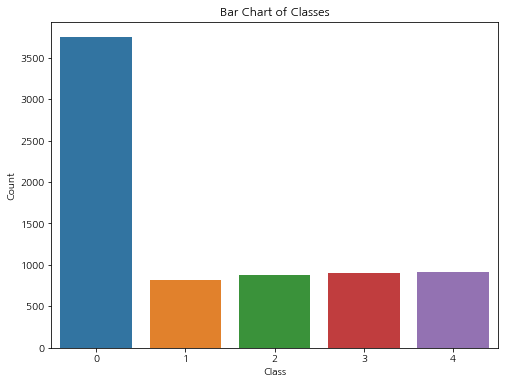

In [73]:
# 클래스별 개수(count) 계산
class_counts = df['class'].value_counts()

# 시각화를 위한 막대 차트 그리기
plt.figure(figsize=(8, 6))  # 그래프 크기 설정 (선택적)

# seaborn의 barplot을 사용하여 막대 차트 그리기
sns.barplot(x=class_counts.index, y=class_counts.values)

# x축 레이블 추가
plt.xlabel('Class')

# y축 레이블 추가
plt.ylabel('Count')

# 그래프 제목 추가
plt.title('Bar Chart of Classes')

# 그래프 보여주기
plt.show()